In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb  # Import wandb for logging
import warnings
warnings.filterwarnings('ignore')

# Log in to WandB using API key (replace <your-wandb-api-key> with your actual API key)
wandb.login()

# Initialize wandb
wandb.init(project="emotion-recognition", name="vgg16-resnet18-experiment", config={
    "epochs": 10,
    "batch_size": 16,
    "model_variants": ["VGG16_finetuned", "ResNet18_scratch", "ResNet18_pretrained"],
    "emotion_classes": ["angry", "happy", "neutral", "surprise"]
})


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yash-chordia (yash-chordia-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [2]:
# Define transformations (augmentations for training, basic for validation/test)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_dir = "/kaggle/input/emotion-data"

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(input_dir,"train"), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(input_dir,"test"), transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define emotion classes
emotion_classes = train_dataset.classes  # 
num_classes = len(emotion_classes)

# Log dataset info to wandb
wandb.config.update({
    "num_classes": num_classes,
    "train_samples": len(train_dataset),
    "test_samples": len(test_dataset)
})

In [3]:
# Load a pretrained VGG16 model as a proxy for VGGFace
class VGGPyTorch(nn.Module):
    def __init__(self, num_classes):
        super(VGGPyTorch, self).__init__()
        # Load pretrained VGG16 from torchvision
        self.vgg = models.vgg16(pretrained=True)
        # Modify the classifier for our number of classes
        num_ftrs = self.vgg.classifier[-1].in_features
        # Replace the last fully connected layer
        self.vgg.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        return self.vgg(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = VGGPyTorch(num_classes).to(device)

# Freeze the feature layers and only finetune the classifier
for param in vgg_model.vgg.features.parameters():
    param.requires_grad = False

# Log model architecture to wandb
wandb.watch(vgg_model, log="all")

In [4]:
# ResNet18 from scratch
resnet18_scratch = models.resnet18(pretrained=False)
num_ftrs = resnet18_scratch.fc.in_features
resnet18_scratch.fc = nn.Linear(num_ftrs, num_classes)
resnet18_scratch = resnet18_scratch.to(device)

# Log model architecture to wandb
wandb.watch(resnet18_scratch, log="all")

In [5]:
# ResNet18 pretrained
resnet18_pretrained = models.resnet18(pretrained=True)
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)
resnet18_pretrained = resnet18_pretrained.to(device)

# Log model architecture to wandb
wandb.watch(resnet18_pretrained, log="all")

In [6]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, model_name=""):
    train_losses, train_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        # Use tqdm for progress bar over batches
        progress_bar = tqdm(train_loader, desc=f'{model_name} Epoch {epoch+1}/{num_epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar with current loss
            progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1)})
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Log metrics to wandb
        wandb.log({
            f"{model_name}_train_loss": epoch_loss,
            f"{model_name}_train_accuracy": epoch_acc,
            "epoch": epoch + 1
        })
        
        print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    return train_losses, train_accuracies

In [7]:
def evaluate_model(model, test_loader, emotion_classes, model_name=""):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        # Use tqdm for progress bar during evaluation
        progress_bar = tqdm(test_loader, desc=f'Evaluating {model_name}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Accuracy per class
    class_accuracies = {}
    for i, emotion in enumerate(emotion_classes):
        mask = np.array(all_labels) == i
        if mask.sum() > 0:
            class_acc = accuracy_score(np.array(all_labels)[mask], np.array(all_preds)[mask]) * 100
            class_accuracies[emotion] = class_acc
            print(f'Accuracy for {emotion}: {class_acc:.2f}%')
            # Log class-wise accuracy to wandb
            wandb.log({f"{model_name}_accuracy_{emotion}": class_acc})
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_classes, yticklabels=emotion_classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Log confusion matrix to wandb
    wandb.log({f"{model_name}_confusion_matrix": wandb.Image(plt)})
    plt.close()
    
    return class_accuracies, cm

In [8]:
# Train VGG16 (proxy for VGGFace)
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.0001)
print("Training VGG16 Model (Proxy for VGGFace)...")
vgg_losses, vgg_accuracies = train_model(vgg_model, train_loader, criterion, optimizer_vgg, num_epochs=wandb.config.epochs, model_name="VGG16")

# Save the trained VGG16 model
vgg_model_path = "/kaggle/working/vgg16_emotion_model.pth"
torch.save(vgg_model.state_dict(), vgg_model_path)
print(f"VGG16 model saved to {vgg_model_path}")
# Log the model file to wandb
wandb.save(vgg_model_path)

# Evaluate VGG16
print("\nEvaluating VGG16 Model (Proxy for VGGFace)...")
vgg_class_accuracies, vgg_cm = evaluate_model(vgg_model, test_loader, emotion_classes, model_name="VGG16")

Training VGG16 Model (Proxy for VGGFace)...


VGG16 Epoch 1/10, Loss: 1.2971, Accuracy: 37.47%


VGG16 Epoch 2/10, Loss: 1.0124, Accuracy: 57.52%


VGG16 Epoch 3/10, Loss: 0.8192, Accuracy: 66.53%


VGG16 Epoch 4/10, Loss: 0.6722, Accuracy: 73.55%


VGG16 Epoch 5/10, Loss: 0.6332, Accuracy: 73.55%


VGG16 Epoch 6/10, Loss: 0.5394, Accuracy: 79.16%


VGG16 Epoch 7/10, Loss: 0.4786, Accuracy: 82.03%


VGG16 Epoch 8/10, Loss: 0.4553, Accuracy: 82.03%


VGG16 Epoch 9/10, Loss: 0.3701, Accuracy: 85.70%


VGG16 Epoch 10/10, Loss: 0.3635, Accuracy: 85.64%


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


VGG16 model saved to /kaggle/working/vgg16_emotion_model.pth

Evaluating VGG16 Model (Proxy for VGGFace)...


Accuracy for angry: 79.66%
Accuracy for happy: 47.46%
Accuracy for neutral: 57.38%
Accuracy for surprise: 54.02%


In [9]:
# Train ResNet18 from Scratch
optimizer_scratch = optim.Adam(resnet18_scratch.parameters(), lr=0.001)
print("Training ResNet18 from Scratch...")
scratch_losses, scratch_accuracies = train_model(resnet18_scratch, train_loader, criterion, optimizer_scratch, num_epochs=wandb.config.epochs, model_name="ResNet18_Scratch")

# Save the trained ResNet18 Scratch model
scratch_model_path = "/kaggle/working/resnet18_scratch_emotion_model.pth"
torch.save(resnet18_scratch.state_dict(), scratch_model_path)
print(f"ResNet18 Scratch model saved to {scratch_model_path}")
# Log the model file to wandb
wandb.save(scratch_model_path)

# Evaluate ResNet18 from Scratch
print("\nEvaluating ResNet18 from Scratch...")
scratch_class_accuracies, scratch_cm = evaluate_model(resnet18_scratch, test_loader, emotion_classes, model_name="ResNet18_Scratch")

Training ResNet18 from Scratch...


ResNet18_Scratch Epoch 1/10, Loss: 1.5049, Accuracy: 26.12%


ResNet18_Scratch Epoch 2/10, Loss: 1.3953, Accuracy: 29.79%


ResNet18_Scratch Epoch 3/10, Loss: 1.3533, Accuracy: 35.47%


ResNet18_Scratch Epoch 4/10, Loss: 1.3354, Accuracy: 35.87%


ResNet18_Scratch Epoch 5/10, Loss: 1.3111, Accuracy: 37.54%


ResNet18_Scratch Epoch 6/10, Loss: 1.2793, Accuracy: 40.35%


ResNet18_Scratch Epoch 7/10, Loss: 1.2674, Accuracy: 42.89%


ResNet18_Scratch Epoch 8/10, Loss: 1.2151, Accuracy: 44.42%


ResNet18_Scratch Epoch 9/10, Loss: 1.1912, Accuracy: 48.23%


ResNet18_Scratch Epoch 10/10, Loss: 1.1390, Accuracy: 49.57%
ResNet18 Scratch model saved to /kaggle/working/resnet18_scratch_emotion_model.pth

Evaluating ResNet18 from Scratch...


Accuracy for angry: 4.24%
Accuracy for happy: 50.85%
Accuracy for neutral: 81.15%
Accuracy for surprise: 3.45%


In [10]:
# Train ResNet18 Pretrained
optimizer_pretrained = optim.Adam(resnet18_pretrained.parameters(), lr=0.0001)
print("Training ResNet18 Pretrained...")
pretrained_losses, pretrained_accuracies = train_model(resnet18_pretrained, train_loader, criterion, optimizer_pretrained, num_epochs=wandb.config.epochs, model_name="ResNet18_Pretrained")

# Save the trained ResNet18 Pretrained model
pretrained_model_path = "/kaggle/working/resnet18_pretrained_emotion_model.pth"
torch.save(resnet18_pretrained.state_dict(), pretrained_model_path)
print(f"ResNet18 Pretrained model saved to {pretrained_model_path}")
# Log the model file to wandb
wandb.save(pretrained_model_path)

# Evaluate ResNet18 Pretrained
print("\nEvaluating ResNet18 Pretrained...")
pretrained_class_accuracies, pretrained_cm = evaluate_model(resnet18_pretrained, test_loader, emotion_classes, model_name="ResNet18_Pretrained")

Training ResNet18 Pretrained...


ResNet18_Pretrained Epoch 1/10, Loss: 0.9602, Accuracy: 59.79%


ResNet18_Pretrained Epoch 2/10, Loss: 0.4331, Accuracy: 83.17%


ResNet18_Pretrained Epoch 3/10, Loss: 0.2504, Accuracy: 91.52%


ResNet18_Pretrained Epoch 4/10, Loss: 0.2272, Accuracy: 92.12%


ResNet18_Pretrained Epoch 5/10, Loss: 0.1318, Accuracy: 95.66%


ResNet18_Pretrained Epoch 6/10, Loss: 0.1164, Accuracy: 96.13%


ResNet18_Pretrained Epoch 7/10, Loss: 0.1250, Accuracy: 95.93%


ResNet18_Pretrained Epoch 8/10, Loss: 0.1012, Accuracy: 96.79%


ResNet18_Pretrained Epoch 9/10, Loss: 0.0877, Accuracy: 97.46%


ResNet18_Pretrained Epoch 10/10, Loss: 0.0514, Accuracy: 98.60%
ResNet18 Pretrained model saved to /kaggle/working/resnet18_pretrained_emotion_model.pth

Evaluating ResNet18 Pretrained...


Accuracy for angry: 82.20%
Accuracy for happy: 74.58%
Accuracy for neutral: 89.34%
Accuracy for surprise: 78.16%


In [11]:
# Plot training curves for all models
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_losses, label='VGG16 (Proxy for VGGFace) Loss')
plt.plot(scratch_losses, label='ResNet18 Scratch Loss')
plt.plot(pretrained_losses, label='ResNet18 Pretrained Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(vgg_accuracies, label='VGG16 (Proxy for VGGFace) Accuracy')
plt.plot(scratch_accuracies, label='ResNet18 Scratch Accuracy')
plt.plot(pretrained_accuracies, label='ResNet18 Pretrained Accuracy')
plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()

# Log the training curves to wandb
wandb.log({"Training Curves": wandb.Image(plt)})
plt.close()

In [12]:

# Creative element: Display a message based on predicted emotion
def display_emotion_message(predicted_emotion):
    import random
    messages = {
        "happy": [
            "You seem happy! Keep smiling!",
            "Happiness suits you well!",
            "Stay positive and spread the joy!"
        ],
        "angry": [
            "You seem angry. Take a deep breath and relax.",
            "It's okay to feel angry sometimes. Try to calm down.",
            "Take a moment to cool off and find your peace."
        ],
        "surprise": [
            "You look surprised! What's the exciting news?",
            "Wow, something unexpected happened?",
            "Surprises make life interesting, don't they?"
        ],
        "neutral": [
            "You seem neutral. Hope you're having a good day!",
            "A calm and neutral mood is always nice.",
            "Stay balanced and enjoy your day!"
        ]
    }
    return random.choice(messages.get(predicted_emotion, ['Emotion not recognized.']))


Total selected images: 20
Video writer for VGG16 released.
Video writer for ResNet18_Scratch released.
Video writer for ResNet18_Pretrained released.
Video for VGG16 saved to /kaggle/working/vgg16_predictions_video.mp4, size: 238886 bytes
Video for ResNet18_Scratch saved to /kaggle/working/resnet18_scratch_predictions_video.mp4, size: 217916 bytes
Video for ResNet18_Pretrained saved to /kaggle/working/resnet18_pretrained_predictions_video.mp4, size: 245631 bytes
Video for VGG16 saved to /kaggle/working/vgg16_predictions_video.mp4
Video for ResNet18_Scratch saved to /kaggle/working/resnet18_scratch_predictions_video.mp4
Video for ResNet18_Pretrained saved to /kaggle/working/resnet18_pretrained_predictions_video.mp4


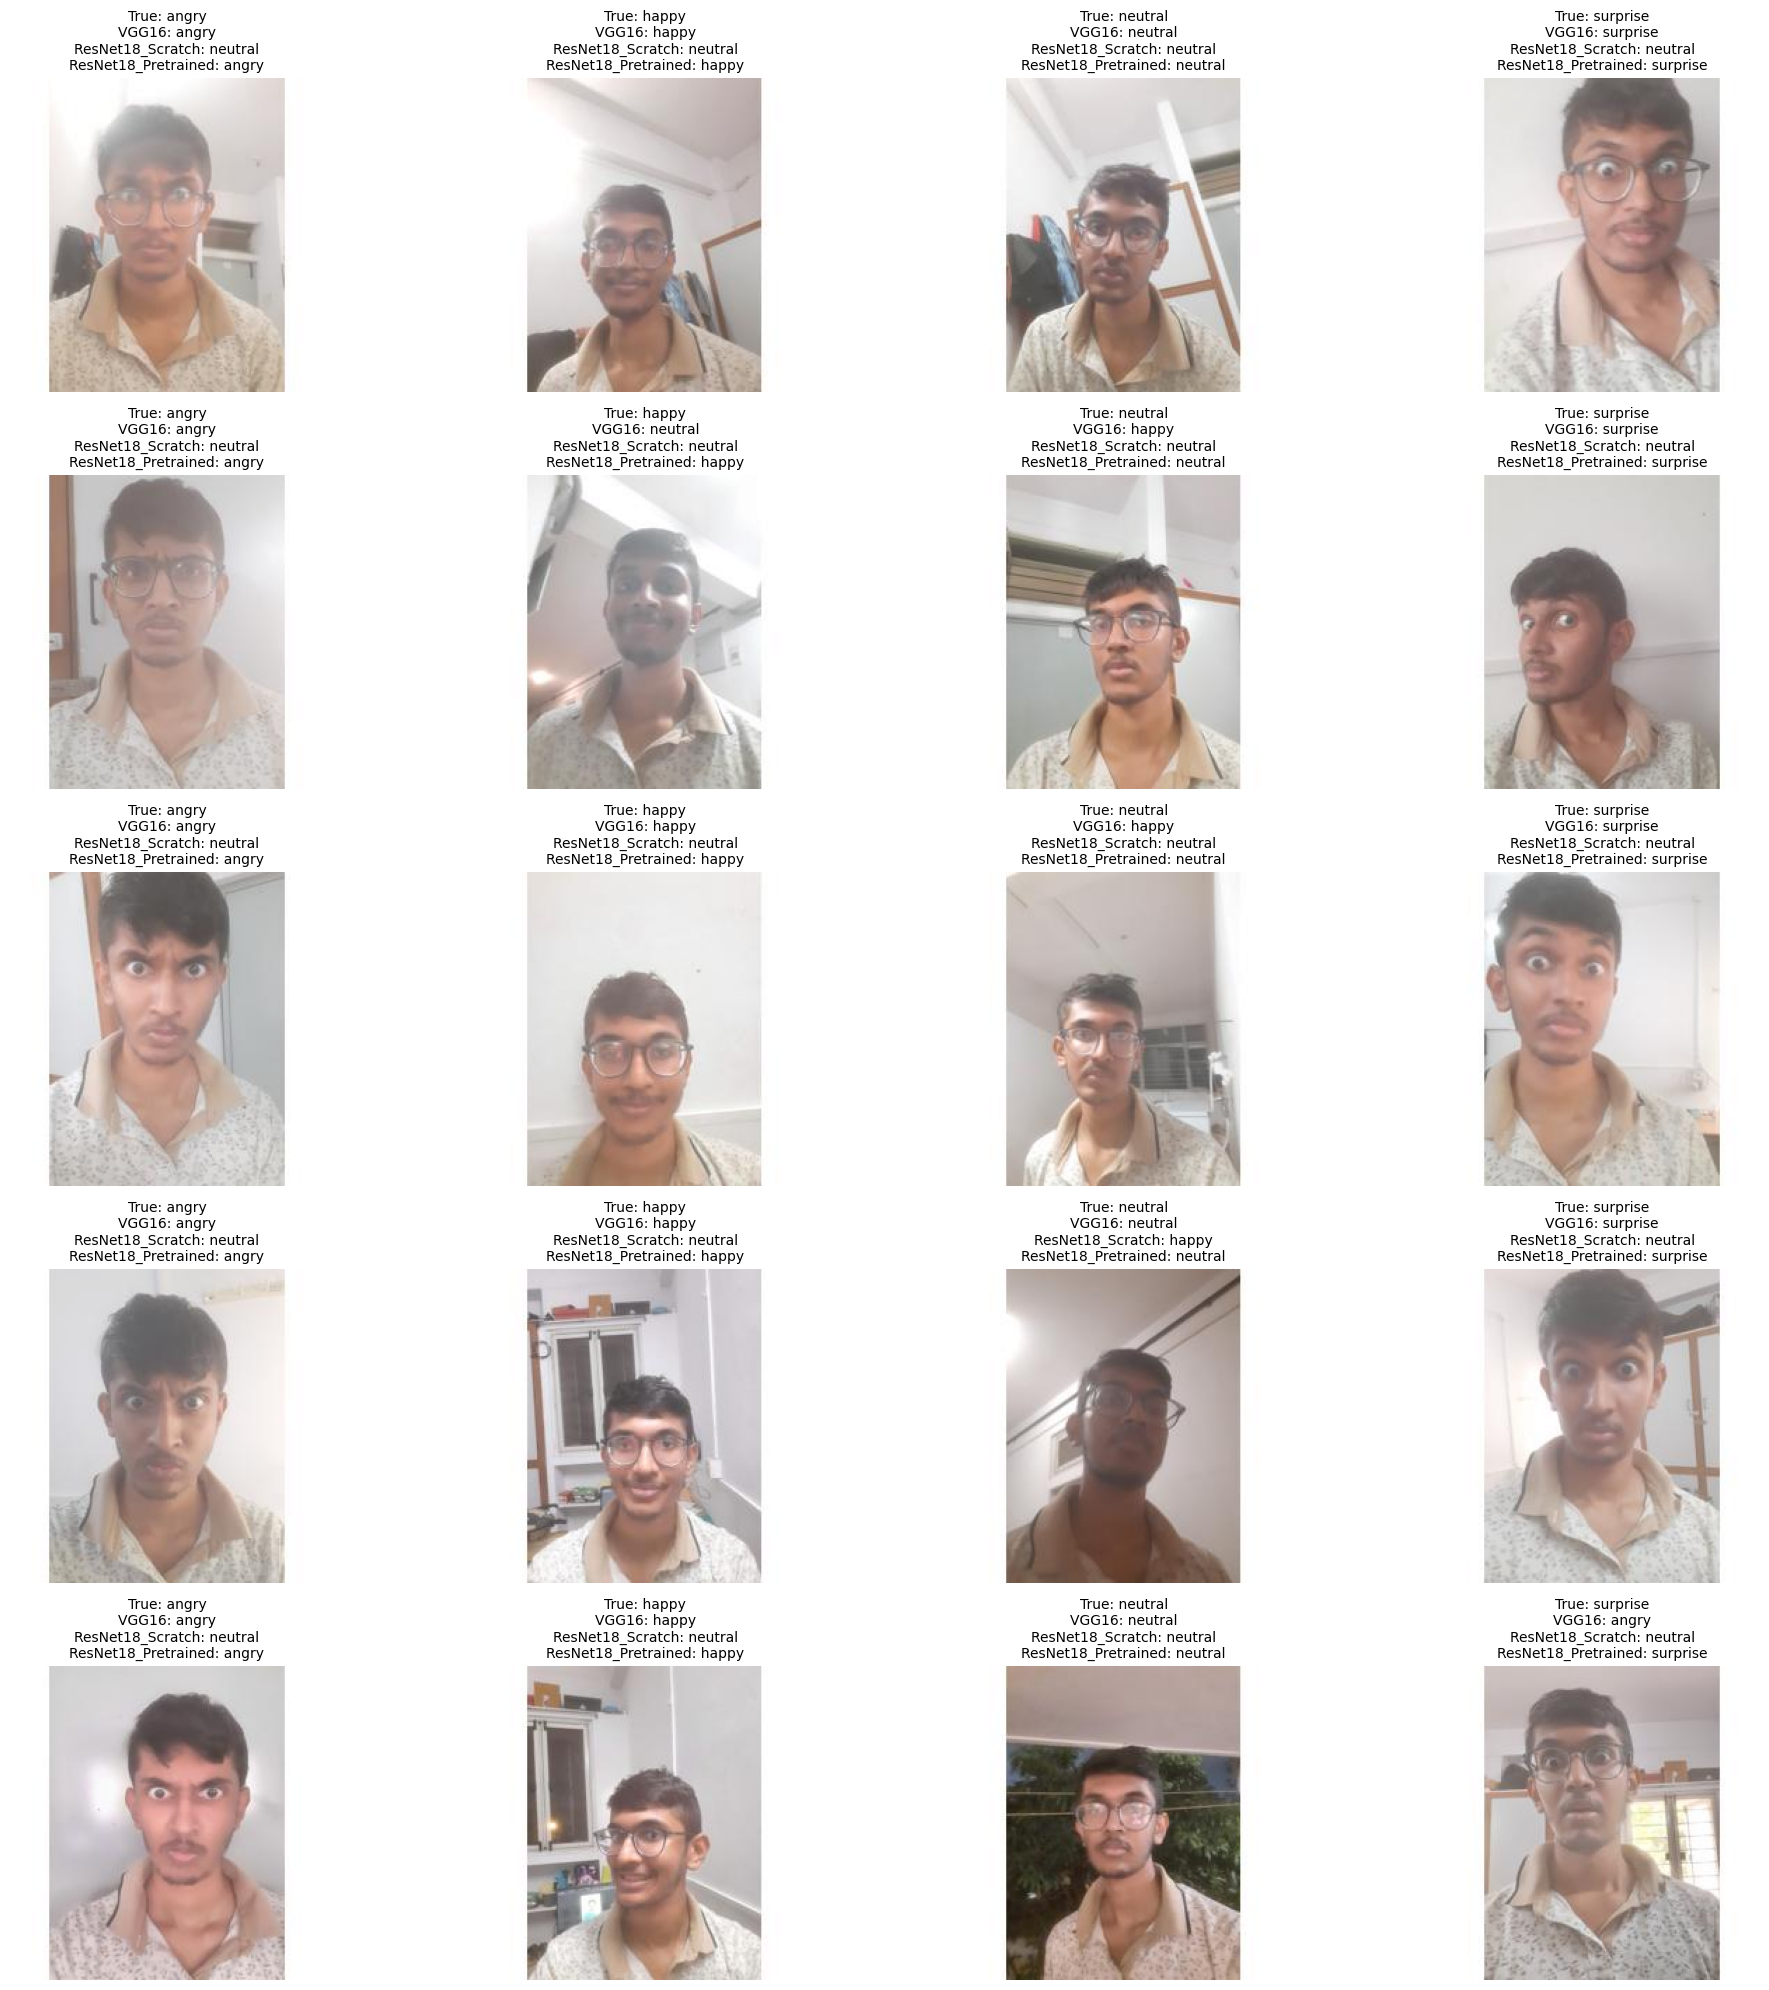

ResNet18_Pretrained_accuracy_angry,▁
ResNet18_Pretrained_accuracy_happy,▁
ResNet18_Pretrained_accuracy_neutral,▁
ResNet18_Pretrained_accuracy_surprise,▁
ResNet18_Pretrained_train_accuracy,▁▅▇▇▇█████
ResNet18_Pretrained_train_loss,█▄▃▂▂▂▂▁▁▁
ResNet18_Scratch_accuracy_angry,▁
ResNet18_Scratch_accuracy_happy,▁
ResNet18_Scratch_accuracy_neutral,▁
ResNet18_Scratch_accuracy_surprise,▁
ResNet18_Scratch_train_accuracy,▁▂▄▄▄▅▆▆██


In [13]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import random
import os
import torch

# Ensure matplotlib displays inline in Kaggle
%matplotlib inline

# Ensure required libraries are installed
!pip install opencv-python-headless

# Define paths for videos
video_paths = {
    "VGG16": "/kaggle/working/vgg16_predictions_video.mp4",
    "ResNet18_Scratch": "/kaggle/working/resnet18_scratch_predictions_video.mp4",
    "ResNet18_Pretrained": "/kaggle/working/resnet18_pretrained_predictions_video.mp4"
}

# Initialize video writers for each model
frame_size = (224, 224)  # Same as input image size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
video_writers = {
    "VGG16": cv2.VideoWriter(video_paths["VGG16"], fourcc, 1, frame_size),  # 1 fps
    "ResNet18_Scratch": cv2.VideoWriter(video_paths["ResNet18_Scratch"], fourcc, 1, frame_size),
    "ResNet18_Pretrained": cv2.VideoWriter(video_paths["ResNet18_Pretrained"], fourcc, 1, frame_size)
}

# Check if video writers are opened successfully
for model_name, writer in video_writers.items():
    if not writer.isOpened():
        print(f"Error: Video writer for {model_name} could not be opened.")
        break

# Define labels
labels = ['angry', 'happy', 'neutral', 'surprise']
models = {
    "VGG16": vgg_model,
    "ResNet18_Scratch": resnet18_scratch,
    "ResNet18_Pretrained": resnet18_pretrained
}

# Prepare data for cyclic selection
test_images = []
test_labels = []
for images, lbls in test_loader:
    test_images.extend(images)
    test_labels.extend(lbls.tolist())
test_images = [img for img, lbl in zip(test_images, test_labels)]

# Group images by label
label_to_images = {lbl: [] for lbl in range(len(emotion_classes))}
for img, lbl in zip(test_images, test_labels):
    label_to_images[lbl].append(img)


# Collect 5 images per label cyclically
selected_images = []
selected_true_labels = []
for cycle in range(5):
    for lbl_idx, lbl in enumerate(labels):
        lbl_idx = emotion_classes.index(lbl)
        img = label_to_images[lbl_idx][cycle % len(label_to_images[lbl_idx])]
        true_label = emotion_classes[lbl_idx]
        selected_images.append(img)
        selected_true_labels.append(true_label)

# Debug: Check if images are loaded correctly
print(f"Total selected images: {len(selected_images)}")

# Denormalize function to restore original colors
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor.clone()  # Avoid modifying the original tensor
    tensor = tensor * std + mean  # Denormalize
    tensor = tensor.clamp(0, 1)  # Ensure pixel values are in [0, 1]
    return tensor

# Predict labels with each model and create videos
all_predictions = {model_name: [] for model_name in models.keys()}
to_pil = ToPILImage()
for idx, (img, true_label) in enumerate(zip(selected_images, selected_true_labels)):
    img_tensor = img.unsqueeze(0).to(device)
    img_denorm = denormalize(img)  # Denormalize for correct colors
    img_pil = to_pil(img_denorm)
    img_np = np.array(img_pil)

    for model_name, model in models.items():
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
            pred_label = emotion_classes[pred.item()]
            all_predictions[model_name].append(pred_label)

        # Create frame with predicted label, actual label, and a message
        frame = img_np.copy()
        text_pred = f"Pred: {pred_label}"
        text_actual = f"Actual: {true_label}"
        message = display_emotion_message(pred_label)
        cv2.putText(frame, text_pred, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        cv2.putText(frame, text_actual, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        cv2.putText(frame, message, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

        # Write the frame multiple times to make the video duration longer (1 fps, so 3 writes = 3 seconds per image)
        for _ in range(3):
            video_writers[model_name].write(frame)

# Release video writers
for model_name, writer in video_writers.items():
    writer.release()
    print(f"Video writer for {model_name} released.")

# Verify video file sizes
for model_name, video_path in video_paths.items():
    if os.path.exists(video_path):
        size = os.path.getsize(video_path)
        print(f"Video for {model_name} saved to {video_path}, size: {size} bytes")
    else:
        print(f"Video for {model_name} not found at {video_path}")

# Log videos to wandb
for model_name, video_path in video_paths.items():
    if os.path.exists(video_path):
        wandb.save(video_path)
        print(f"Video for {model_name} saved to {video_path}")

# Display all images with their predicted labels
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()
for idx, (img, true_label) in enumerate(zip(selected_images, selected_true_labels)):
    img_denorm = denormalize(img)  # Denormalize for correct colors
    img_pil = to_pil(img_denorm)
    axes[idx].imshow(img_pil)
    pred_labels = [f"{model_name}: {all_predictions[model_name][idx]}" for model_name in models.keys()]
    title = f"True: {true_label}\n" + "\n".join(pred_labels)
    axes[idx].set_title(title, fontsize=10)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

# Log the grid to wandb
wandb.log({"Prediction Grid": wandb.Image(plt)})
plt.close()
wandb.finish()